# DEEP LEARNING - FINAL PROJECT ETL

Jesús Moncho <br>
Helen Navarro <br>
Ruben Tenreiro <br>
Marco Hernani <br>

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
import cv2
import os

## Loading images

We will need to load the images. We are going to use <a href = "https://opencv.org/"> cv2</a> for that. OpenCV-Python is a library of Python bindings designed to solve computer vision problems.

Our model needs the image size to be consistent across the board. Hence we defined a variable called `image_size` that's a tuple with the height and width in pixels of the images!

In [2]:
image_size = (300, 300)

Now we define a function that will read the images in a given directory and store them in a list. To do so, it uses cv2, and the images will be transfomed in matrices. This function will then return a list of matrices of the size previously defined, each representing an image in the directory passed as an argument! It will also store the corresponding label for that image, depending on whether the image belongs to a pacient with **pneumonia** (**`1`**) or to a **healthy** patient (**`0`**).

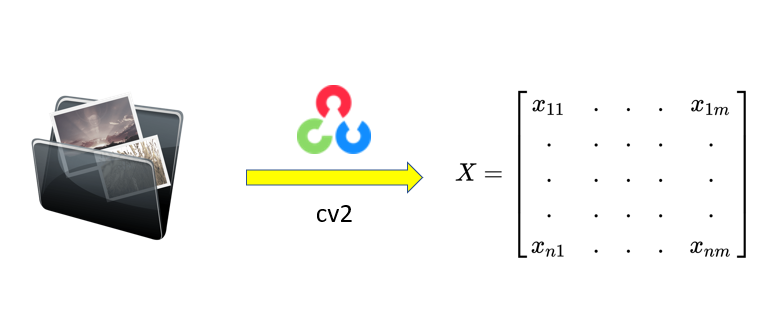

In [3]:
def load_images(_path, _image_size, _label):
    
    """_path: path of the folder that contains the images
    _label: label of the images
    _image_size: tuple with the size of the image
    return: a list of tuples where the first item is the image as a 2d array
    and the label for all the images"""
    
    files_names = os.listdir(_path)
    
    labeled_images = []
    
    for file_name in files_names:
        image = cv2.imread(f"{_path}/{file_name}", cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, _image_size)
        labeled_images.append((image, _label))
        
    return labeled_images

Now we use this function to load the training images provided for the exercise:

In [4]:
#Data needed to train our model
#Labels, 0:normal and 1:pneumonía
train_data = load_images("datasets/train/PNEUMONIA", image_size, 1)
aux_data = load_images("datasets/train/NORMAL", image_size, 0)

train_data.extend(aux_data)

Here's an example of an image opened with the `cv2` library, as an image.

In [5]:
# cv2.imshow("train", train_data[0][0])
# cv2.waitKey(0)
# cv2.destroyAllWindows

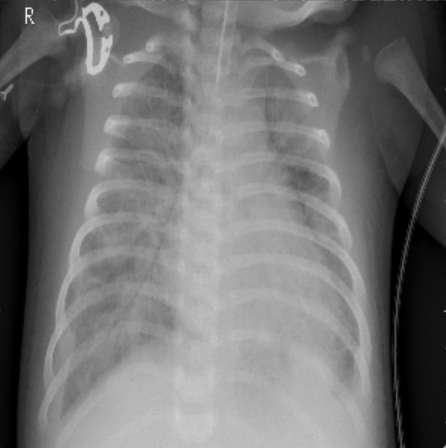

And here we can see what's been stored in the variable, a tuple containing a matrix that represents the image as its first element and a boolean label as its second element.

In [6]:
train_data[0]

(array([[18, 19, 24, ...,  5,  2,  0],
        [19, 21, 24, ...,  6,  3,  0],
        [18, 22, 24, ...,  7,  5,  0],
        ...,
        [10, 10, 10, ..., 15, 15, 15],
        [10, 10, 10, ..., 15, 15, 15],
        [10, 10, 10, ..., 15, 15, 15]], dtype=uint8),
 1)

Now we do the same for the test images:

In [7]:
#Data needed to train our model
#Labels, 0:normal and 1:pneumonía
test_data = load_images("datasets/test/PNEUMONIA", image_size, 1)
aux_data = load_images("datasets/test/NORMAL", image_size, 0)

test_data.extend(aux_data)

In [8]:
# cv2.imshow("test", test_data[0][0])
# cv2.waitKey(0)
# cv2.destroyAllWindows

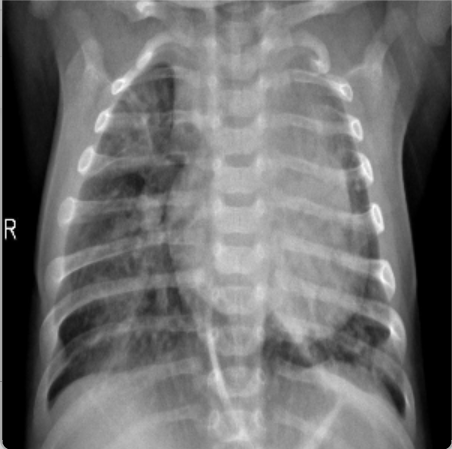

In [9]:
test_data[0]

(array([[22, 17, 17, ..., 86, 88, 86],
        [21, 16, 15, ..., 91, 89, 89],
        [20, 15, 18, ..., 95, 84, 83],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 1)

## Data augmentation

Our next step is to have a quick look at how our data is distributed to see how our features are distributed. We plot the number of sick and healthy patients in a bar chart:

In [10]:
healthy = len(list(filter(lambda x: not x[1], train_data)))
pneumonia = len(list(filter(lambda x: x[1], train_data)))

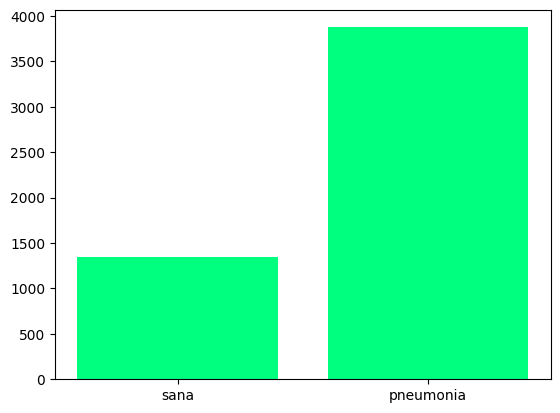

In [11]:
bar_data = (healthy, pneumonia)
plt.bar(["sana", "pneumonia"], bar_data, color = "springgreen")
plt.show()

In [12]:
# Also exploring the distribution of the classes in the training data

train_pneu = list( filter(lambda x: x[1], train_data ) )
train_normal = list( filter(lambda x: not x[1], train_data ) )

print(f"Muestras con pneumonia: {round(len(train_pneu)/len(train_data)*100, 2)}%")
print(f"Muestras sin pneumonia: {round(len(train_normal)/len(train_data)*100, 2)}%")

Muestras con pneumonia: 74.29%
Muestras sin pneumonia: 25.71%


Since our classes are considerably imbalanced, we decided to create new images of healthy people off of the images that we already have!

## Data Augmentation

Of all the available methods to generate new images, we thought of a very simple and efficient one. Since our images are just matrices, we thought that by transposing our matrices we'd be rotating the images 90 degrees.

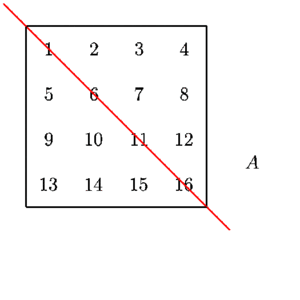

In numpy, we can just use `matrix.T` to do this. It's a very simple and fast method that doesn't require any additional libraries. Here's an example of what it does!

In [13]:
#We add images of healthy people

for x, _ in train_normal[:]:
    train_data.append((x.T, 0))

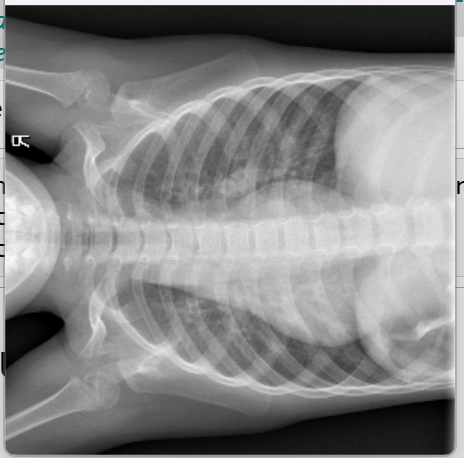

By doing this, we should've doubled up the number of images of healthy people. Let's check the class balance again!

In [14]:
train_pneu = list( filter(lambda x: x[1], train_data ) )
train_normal = list( filter(lambda x: not x[1], train_data ) )

print(f"Muestras con pneumonia: {round(len(train_pneu)/len(train_data)*100, 2)}%")
print(f"Muestras sin pneumonia: {round(len(train_normal)/len(train_data)*100, 2)}%")

Muestras con pneumonia: 59.1%
Muestras sin pneumonia: 40.9%


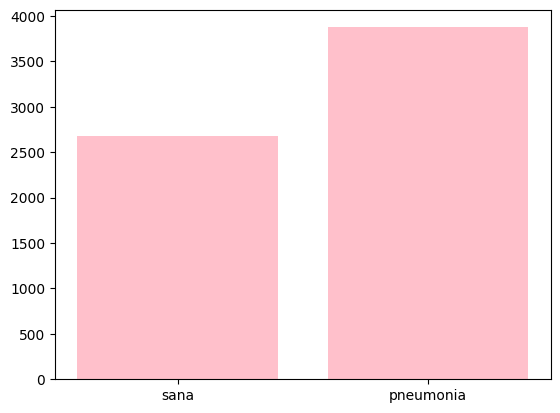

In [15]:
bar_data = (len(train_normal) , len(train_pneu) ) 
plt.bar(["sana", "pneumonia"], bar_data, color = "pink")
plt.show()

Now our data is closer to be balanced. We've considered that this ratio is good enough for the model.

# Getting the data ready for the model

Our data is almost ready. All that's left is to split it into `X` and `y`, normalize it and transform it into a format that's feedable to the model!

From the `traind_data`, where our data is stored in tuples `(matrix, label)` we want to go to: 
* `train_X` -> matrices
* `train_y` -> labels
* `test_X` -> matrices
* `text_y` -> labels

For the **normalization**, we will divide the values in our matrices by 255. Why? Because the pixel values in a grayscale image will always be in the range `[0, 255]`. This will transform our values to floats in the range `[0, 1]`.

Lastly, we transform our lists to numpy arrays so that our model can be fed directly these elements! To do so we just use `np.array(our_array_name, dtype = "float 32")`

In [16]:
#Outputs
train_y = []

#Inputs
train_X = []

for x, y in train_data:
    train_y.append(y)
    train_X.append(x)
    
train_y = np.array(train_y, dtype='float32')

#Why do We divide by 255? is because We need values between 0 and 1?
train_X = np.array(train_X, dtype='float32')/255

Here we can see an image after normalizing it!

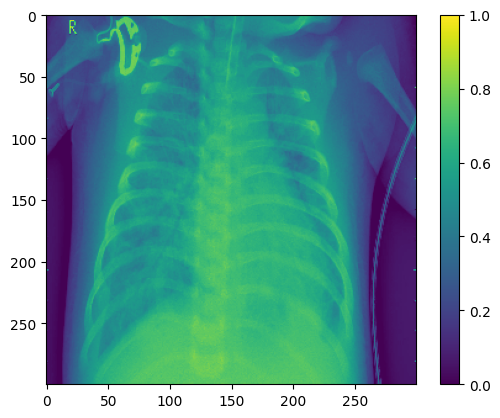

In [17]:
plt.figure()
plt.imshow(train_X[0])
plt.colorbar()
plt.grid(False)
plt.show()

We follow the same process for the images in our test set!

In [18]:
#Outputs
test_y = []

#Inputs
test_X = []

for x,y in test_data:
    test_y.append(y)
    test_X.append(x)
    
test_y = np.array(test_y, dtype='float32')

test_X = np.array(test_X, dtype='float32')/255

# Creating the model

We've used the <a href = "https://keras.io/api/models/sequential/">**`keras.Sequential()`**</a> class to build our neural network. 

We've played around with a few parameters, such as the number of layers in our model, the number of nodes per layer and different activation functions. We've chosen the ones that worked best based on the accuracy of the different models that we tried when evaluating them on the test set!

As an additional note, for the output layer we've chosen 1 node and `activation = "sigmoid"` because the sigmoid function usually performs very well in binary classification, which is our case.

To use the sigmoid function as output layer, the model needs to be compiled with `binary_crossentropy` as the loss function.

In [ ]:
#Model creation

model = Sequential([
  Flatten(input_shape=image_size),
  Dense(32, activation='relu'),
  Dropout(0.3),
  Dense(4, activation='relu'),
  Dense(1, activation="sigmoid")
])

#Model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              #loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Once we've defined our model, we need to training. To do so, we use `model.fit()`. As arguments, we pass the 
* `train_X` 
* `train_y` 
* `validation_data`, which is a tuple with the validation set. In our case `(test_X, test_y)`
* `epochs`

In [ ]:
%%timeit -r 1 -n 1

tf.keras.utils.set_random_seed(42)

model.fit(
        train_X, train_y, 
        validation_data = (test_X, test_y), 
        epochs = 16
    )

Now we evaluate how well our model predicts using `model.evaluate()` with both the training and test sets:

In [ ]:
model.evaluate(train_X,  train_y, verbose=2)

In [ ]:
model.evaluate(test_X,  test_y, verbose=2)

The lines below, now commented, are used to save our models so that we can choose the ones that perform better and load them in the future, without the need of retraining them again from scratch.

In [ ]:
#Save the model once it's stored
#model.save("pneumonia_recognizer.hSpy"